## Importing Dependencies

In [1]:
import cv2 # OpenCV: Preprocess data
import tensorflow as tf # Neural Network
import os 
import numpy as np # Preprocess data
from matplotlib import pyplot as plt # Render results
from typing import List # Typed Annotations
import imageio # Create GIFs of NumPy arrays

#### Preventing machine from running out of memory errors

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Preventing exponential growth of GPU memory usage
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## Data Loading Functions

#### Function A: Load Videos

In [3]:
# Getting data into Video Loading Function
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path) # Video Capture Object
    frames = []

    # Looping through all the frames and storing them in 'frames'
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) # RGB -> Greyscale (Less data to pre-process)
        frames.append(frame[190:236,80:220,:]) # Static slicing of the mouth region 
    cap.release() # Release the Video Capture Object

    mean = tf.math.reduce_mean(frames) # Mean of the frames
    std  = tf.math.reduce_std(tf.cast(frames, tf.float32)) # Standard deviation of the frames
    scale = tf.cast((frames - mean), tf.float32) / std # Scale/Standarize the frames

    return scale

Automatic Speech Recognition using CTC

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# Tokenizing text with StringLookup
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token="")

print(
    f"The Vocabulary is: {char_to_num.get_vocabulary()}",
    f"(size = {char_to_num.vocabulary_size()})"
)

The Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


#### Function B: Load Alignments

In [5]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    
    # Splitting each line in the path file
    for line in lines:
        line = line.split()
        # If the line is not 'sil' (silence), then append the token
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]

    # Converting from characters to numbers
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), [-1]))[1:]

#### Function C: Load Data

In [6]:
# This is to load the preprocessed videos and alignments simultaneously

def load_data(path: str):
    path = bytes.decode(path.numpy()) # (E.g. './data/s1/bba17n.mpg')
    file_name = path.split('/')[-1].split('.')[0] # Splitting for MacOS 
    # E.g. ('./data/s1/bba17n.mpg' -> 'bba17n')
    # file_name = path.split('\\')[-1].split('.')[0] # Splitting for Windows

    # Paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path) # Function A
    alignments = load_alignments(alignment_path) # Function B

    return frames, alignments

Test

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


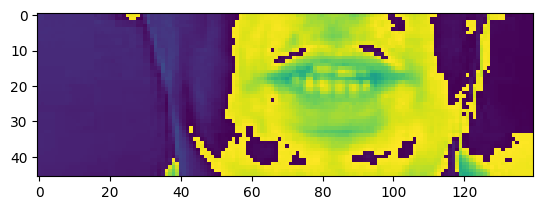

In [7]:
test_path = './data/s1/bbal6n.mpg'
frames, alignments = load_data(tf.convert_to_tensor(test_path))

# Frames
plt.imshow(frames[40]) # the first frame that we preprocessed

# Alignments
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

#### Function D: Mapping

In [8]:
# To use tenserflow pipelines, we need to wrap it in tf.py_function

def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Creating Data Pipeline

In [9]:
# from matplotlib import pyplot as plt

data = tf.data.Dataset.list_files('./data/s1/*.mpg') # Looking for all .mpg files
data = data.shuffle(500, reshuffle_each_iteration=False) # Shuffling the dataset
data = data.map(mappable_function)

# Padding batch for variable alignment sizes in group sizes of 2
# 75 frames for each video, 40 tokens for each alignment
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) 

data = data.prefetch(tf.data.AUTOTUNE) # Optimizing the data pipeline

# Added for split 
train = data.take(450) # First 450 samples for training
test = data.skip(450) # Anything after that for testing in Training.ipynb

Test

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by i nine soon'>

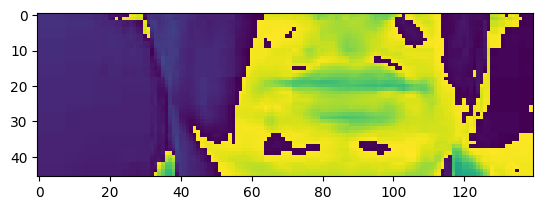

In [10]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]

plt.imshow(val[0][0][0]) # 0: videos, 0: 1st video, 0: 1st frame

tf.strings.reduce_join([num_to_char(w) for w in val[1][0]])

## Neural Network

In [11]:
# Importing the required libraries
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

Libraries Definition:

- Conv3D (3D Convolutional Layer) -> For video classification/processing
LSTM (Long Short Term Memory Layer) -> Give us our current neural network architecture
-  Dense, Dropout, Bidirectional -> Layers to parse through temporal component while using LSTM
- MaxPool3D (3D Max Pooling Layer) -> To reduce the spatial dimensions of the output volume
- Activation (Activation Layer) -> To introduce non-linearity to the model
- Reshape (Reshape Layer) -> To reshape the output of the previous layer to a 2D tensor
- SpatialDropout3D (3D Spatial Dropout Layer) -> To prevent overfitting
- BatchNormalization (Batch Normalization Layer) -> To normalize the activations of the previous layer at each batch
- TimeDistributed (Time Distributed Layer) -> To apply a Dense layer to each of the time steps
- Flatten (Flatten Layer) -> To flatten the input
- Adam -> Adam Optimizer
- ModelCheckpoint (Model Checkpoint Callback) -> save the model after every epoch
- LearningRateScheduler (Learning Rate Scheduler Callback) -> Start out fast and slow down as we get to our optimization

#### Convolutions

In [13]:
model = Sequential() # Initializing the model

# Conv3D(128, 3 ... -> 128 3D Convolutional Kernels with 3x3x3 size
# input_shape -> input shape being passed to neural network
# Padding -> Same (Preserve shape of the inputs)
# Activation -> ReLU (Non Linearity)

model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same', activation='relu'))
model.add(MaxPool3D((1,2,2))) # Taking max data and condesing the data in 2X2 sqaure

model.add(Conv3D(256, 3, padding='same', activation='relu'))
model.add(MaxPool3D((1,2,2))) # Condesing the data

model.add(Conv3D(75, 3, padding='same', activation='relu'))
model.add(MaxPool3D((1,2,2))) # Condesing the data

model.add(TimeDistributed(Flatten())) # Have 75 inputs in our network

#### LSTM

In [14]:
# LSTM -> 128 LSTM units
# Return_Sequence True -> Return all 75 units 

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='Orthogonal')))
model.add(Dropout(0.5)) # Dropping 50% of the units

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='Orthogonal')))
model.add(Dropout(0.5))

# To drop the LSTMs and have 40 + 1 outputs
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

Expected Output

In [15]:
model.summary() # Summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 11, 35, 256)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                        

Convolution Output:
-   (None, 75, 5, 17, 75) -> 75 frames, 5 rows, 17 columns, 75 channels
-   75 -> One output for each frame that we pass through the network
-   (None, 75, 6375) -> 75 frames, 6375 units (after flattening to preserve temporal information)

LSTM Output:
-   (None, 75, 256) -> 75 frames, 256 units (128x2 because of Bidirectional)
-   (None, 75, 41) -> 75 frames, 41 units (40 + 1 because of Dense)
-   41 -> One hot encoded vector respresentation of our final output

Rough Prediction

In [16]:
yhat = model.predict(val[0]) # Predicting the output

# Greedy: Grabbing the max return back from the model and showing what model is predicting
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll????????553'>

## Training

Learning Rate Scheduler

In [17]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    # If we are not below 30 epochs, we will drop it down
    return lr * tf.math.exp(-0.1)

CTC Loss (from Keras)

In [18]:
def CTCLoss(y_true, y_pred):
    batch_len    = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # y_true -> alignments
    # y_pred -> one hot encoded predictions
    # input_length -> length of the predictions (75)
    # label_length -> 40
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

Outputting set of predictions

In [19]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    # Calling the function on the end of each epoch
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            # Original Annotation          
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            # Prediction
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

Compiling the model

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

Callbacks

In [21]:
# To save our model checkpoints every epoch
# save_weights_only=True -> Redefine our model in order to load the weights
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), save_weights_only=True, monitor='loss')

# Defining where we will be saving our model
# Drop the learning rate each epoch
schedule_callback = LearningRateScheduler(scheduler)

# Make predictions
example_callback = ProduceExample(test)

#### Training the model (Fitting the model)

In [ ]:
# Training the model
model.fit(data, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## Predictions

Load the model

In [23]:
model.load_weights('models/checkpoint')

Sample of the data

In [24]:
test_data = test.as_numpy_iterator()

Next Data

In [25]:
sample = test_data.next()

[mpeg1video @ 0x292b9cac0] ac-tex damaged at 22 17
[mpeg1video @ 0x292b9cac0] Warning MVs not available


Generating Prediction

In [26]:
yhat = model.predict(sample[0]) # Passing the sample to make predictions

# Converting the labels to text
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

1/1 [==============================] - 3s 3s/step


#### Prediction

Real Text

In [27]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at m two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red at k nine again'>]

Prediction

In [28]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at m two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red at k nine again'>]

#### Video Prediction

Video

In [30]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

# Real annotation
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

Predicted Text

In [31]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0)) # Predicted text

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

1/1 [==============================] - 1s 1s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]